In [3]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Polygon
from shapely.geometry import Point, LineString, MultiPolygon, MultiLineString, shape

In [290]:
class Lane:
    __slots__ = ["queue", "length"]
    def __init__(self, length):
        self.queue = []
        self.length = length
        
    def __repr__(self):
        s = [vehicle.position for vehicle in self.queue]
        return str(s)
    
    def is_empty(self):
        return len(self.queue) == 0
    
    def get_gap(self):
        if self.queue:
            return self.queue[0].position
        else:
            return self.length
        
    def insert(self, vehicle):
        assert vehicle.position < self.length
        if self.is_empty():
            self.queue.append(vehicle)
        else:
            for i in range(self.length):
                assert vehicle.position != self.queue[i].position
                if vehicle.position < self.queue[i].position:
                    self.queue.insert(i, vehicle)
                    break
            else:
                self.queue.append(vehicle)
            

class Road:
    __slots__ = ["lanes", "nexts", "world"]
    def __init__(self, length=100, nlanes=3):
        self.nexts = {}
        self.lanes = []
        for i in range(nlanes):
            self.lanes.append(Lane(length))
    
    @property
    def length(self):
        return self.lanes[0].length
    
    @property
    def nlane(self):
        return len(self.lanes)
    
    def connect(self, next_road, dlane):
        for i, _ in enumerate(self.lanes):
            ilane = i + dlane
            if ilane >= 0 and ilane < next_road.nlane:
                self.nexts[i] = (next_road, ilane)
                
    def get_gap(self, ilane):
        return self.lanes[ilane].get_gap()
    
    def get_free_lane(self):
        free_lanes = [i for i, lane in enumerate(self.lanes) if lane.get_gap()>0]
        if free_lanes:
            return random.choice(free_lanes)
        else:
            return None
    
    def insert_vehicle(self, vehicle, ilane):
        lane = self.lanes[ilane]
        if not lane.is_empty():
            assert vehicle.position < lane.queue[-1].position
            
        lane.insert(vehicle)
        
    def dispatch_request(self):
        pass
    
    def clear_request(self):
        pass
    
    def collect_information(self):
        for i, lane in enumerate(self.lanes):
            if lane.is_empty():
                continue
                
            # for queuing vehicles
            if len(lane.queue) > 1:
                for vehicle, front_vehicle in zip(lane.queue[:-1], lane.queue[1:]):
                    vehicle.information["front_gap"] = front_vehicle.position - vehicle.position - 1
                    
            # for the last vehicle
            vehicle = lane.queue[-1]
            front_gap = self.length - vehicle.position - 1
            
            next = self.nexts.get(i, None)
            if next is None:
                front_gap += 100
            else:
                next_road, next_ilane = next
                front_gap += next_road.get_gap(next_ilane)
                
            vehicle.information["front_gap"] = front_gap

    def enquire_decision(self):
        for lane in self.lanes:
            if lane.is_empty():
                continue
                
            for vehicle in lane.queue:
                vehicle.make_decision()
    
    def execute_decision(self):
        for i, lane in enumerate(self.lanes):
            if lane.is_empty():
                continue
                
            for vehicle in lane.queue:
                vehicle.position += vehicle.speed
            
            if lane.queue[-1].position >= lane.length:
                last = lane.queue.pop()
                last.position -= lane.length
                
                next = self.nexts.get(i, None)
                if next is None:
                    vehicle.information["exit_time"] = self.world.time
                    print(vehicle, vehicle.information["enter_time"],
                         "->", vehicle.information["exit_time"])
                else:
                    next_road, next_ilane = next
                    next_road.insert_vehicle(last, next_ilane)


class Vehicle:
    __slots__ = ["max_speed", "speed", "horizontal_speed", "position", "information"]
    
    @classmethod
    def get_vehicle(cls):
        vehicle = Vehicle(np.random.randint(5,9))
        vehicle.information["destination"] = np.random.randint(0,2)
        return vehicle
    
    def __init__(self, max_speed):
        self.max_speed = max_speed
        self.speed = 0
        self.position = 0
        self.horizontal_speed = 0
        self.information = {}
    
    def __repr__(self):
        return "Vehicle ({})".format(id(self))
    
    def make_decision(self):
        if self.speed < self.max_speed:
            self.speed += 1
            
        if self.speed > self.information["front_gap"]:
            self.speed = self.information["front_gap"]
                
        if np.random.rand() < 0.1:
            self.speed -= 1
            
        if self.speed < 0:
            self.speed = 0

class Source:
    __slots__ = ["queue", "average_headway", "residule", "next", "world"]
    def __init__(self, average_headway):
        self.average_headway = average_headway
        self.queue = []
        self.next = None
        self.residule = -0.1
    
    def connect(self, next_road):
        self.next = next_road
        
    def step(self):
        if self.residule <= 0.0:
            self.residule += np.random.exponential(self.average_headway)
        
        self.residule -= 1.0
        if self.residule <= 0.0:
            vehilce = Vehicle.get_vehicle()
            self.queue.append(vehilce)
            
        if self.next and self.queue:
            free_lane = self.next.get_free_lane()
            if free_lane is not None:
                vehicle = self.queue.pop(0)
                vehicle.information["enter_time"] = self.world.time
                self.next.insert_vehicle(vehicle, free_lane)

class World:
    __slots__ = ["time", "roads", "sources"]
    def __init__(self):
        self.roads = []
        self.sources = []
        self.time=0
        
    def add_road(self, length, nlane):
        road = Road(length, nlane)
        road.world = self
        self.roads.append(road)
        return road
    
    def add_source(self, average_headway):
        source = Source(average_headway)
        source.world = self
        self.sources.append(source)
        return source
    
    def step(self):
        for source in self.sources:
            source.step()
            
        self.dispatch_request()
        self.collect_information()
        self.enquire_decisions()
        self.execute_decisions()
        
        self.time += 1
        
    def dispatch_request(self):
        for road in self.roads:
            road.dispatch_request
    
    def collect_information(self):
        for road in self.roads:
            road.collect_information()
            
        for road in self.roads:
            road.clear_request()
    
    def enquire_decisions(self):
        for road in self.roads:
            road.enquire_decision()
    
    def execute_decisions(self):
        for road in self.roads:
            road.execute_decision()

In [351]:
car_artists = {}
def draw_road(ax, road, x, y, cell_size, is_ani):
    if not is_ani:
        ax.plot([x*cell_size, (x+road.length)*cell_size], [-y*cell_size, -y*cell_size], "black",
               linewidth=1)
        ax.plot([x*cell_size, (x+road.length)*cell_size],
                [(-y-road.nlane)*cell_size, (-y-road.nlane)*cell_size], "black", linewidth=1)

        for i in range(1, road.nlane):
            ax.plot([x*cell_size, (x+road.length)*cell_size], [(-y-i)*cell_size, (-y-i)*cell_size], 
                    "b--", linewidth=1, alpha=0.6)
        
    xs = []
    ys = []
    for i, lane in enumerate(road.lanes):
        for vehicle in lane.queue:
            xs.append((x + vehicle.position + 0.5) * cell_size)
            ys.append((-y - i - 0.5)*cell_size)
    
    if not is_ani:
        artist = ax.plot(xs, ys, "r>", markersize=3)
        car_artists[id(road)] = artist[0]
    else:
        car_artists[id(road)].set_data(xs, ys)
    

def draw_simulation_world(ax, world, *, cell_size=10, is_ani=False):
    road1, road2, road3 = world.roads[:3]
    ramp1, ramp2 = world.roads[3:]
    width = (road1.length + road2.length + road3.length) * cell_size
    
    if not is_ani:
        ax.clear()
        ax.set_xlim(-20, width+20)
        ax.set_ylim(-100, 100)
        ax.set_aspect(1)
    
    draw_road(ax, road1, 0, 0, cell_size, is_ani)
    draw_road(ax, road2, road1.length, 0, cell_size, is_ani)
    draw_road(ax, road3, road1.length+road2.length, 0, cell_size, is_ani)
    draw_road(ax, ramp1, road1.length-ramp1.length, 3, cell_size, is_ani)
    draw_road(ax, ramp2, road1.length+road2.length, 3, cell_size, is_ani)

In [352]:
world = World()
road1 = world.add_road(50, 3)
road2 = world.add_road(30, 4)
road3 = world.add_road(50, 3)
ramp1 = world.add_road(40, 1)
ramp2 = world.add_road(40, 1)

source1 = world.add_source(1.0)
source2 = world.add_source(4.0)

road1.connect(road2, 0)
road2.connect(road3, 0)
ramp1.connect(road2, 3)
road2.connect(ramp2, -3)

source1.connect(road1)
source2.connect(ramp1)

In [353]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

draw_simulation_world(ax, world, is_ani=False)
def update(frame):
    draw_simulation_world(ax, world, is_ani=True)
    world.step()
    return list(car_artists.values())
    
ani = FuncAnimation(fig, update, frames=40, blit=True)
ani.save("simulation.mp4", fps=5)
        

Vehicle (139646628121720) 1 -> 19
Vehicle (139646635211016) 0 -> 20
Vehicle (139646628121560) 0 -> 23
Vehicle (139646627133944) 5 -> 24
Vehicle (139646628120520) 2 -> 24
Vehicle (139646627976360) 2 -> 24
Vehicle (139646627030264) 3 -> 25
Vehicle (139646628095704) 6 -> 26
Vehicle (139646640191832) 7 -> 26
Vehicle (139646640206776) 5 -> 26
Vehicle (139646628120760) 4 -> 27
Vehicle (139646640226776) 9 -> 28
Vehicle (139646627145512) 8 -> 28
Vehicle (139646640192312) 11 -> 30
Vehicle (139646640170872) 12 -> 31
Vehicle (139646640114408) 10 -> 31
Vehicle (139646628022856) 14 -> 32
Vehicle (139646635734424) 13 -> 37
Vehicle (139646633983816) 21 -> 37
Vehicle (139646640193432) 11 -> 38
Vehicle (139646633983176) 16 -> 38
Vehicle (139646633924152) 15 -> 39
Vehicle (139646640095128) 17 -> 39
Vehicle (139646627147352) 18 -> 41


In [316]:
for i in range(40):
    world.step()

Vehicle (139646626509592) 58 -> 81
Vehicle (139646634466904) 62 -> 81
Vehicle (139646635979384) 66 -> 82
Vehicle (139646626028344) 62 -> 84
Vehicle (139646571789912) 60 -> 85
Vehicle (139646635792168) 61 -> 85
Vehicle (139646635793128) 65 -> 86
Vehicle (139646639360824) 64 -> 86
Vehicle (139646626302936) 63 -> 88
Vehicle (139646637684840) 69 -> 88
Vehicle (139646573701944) 67 -> 89
Vehicle (139646635790728) 70 -> 90
Vehicle (139646626301096) 66 -> 93
Vehicle (139646635792808) 68 -> 94
Vehicle (139646641078904) 73 -> 95
Vehicle (139646635963320) 76 -> 96
Vehicle (139646635964520) 73 -> 96
Vehicle (139646634469000) 78 -> 97
Vehicle (139646634958664) 72 -> 98
Vehicle (139646581635736) 71 -> 98
Vehicle (139646634484744) 75 -> 99
Vehicle (139646634420568) 79 -> 100
Vehicle (139646637324392) 78 -> 100
Vehicle (139646627117480) 81 -> 101
Vehicle (139646635514280) 74 -> 101
Vehicle (139646572522376) 80 -> 103
Vehicle (139646638545960) 77 -> 103
Vehicle (139646626028344) 85 -> 104
Vehicle (1396

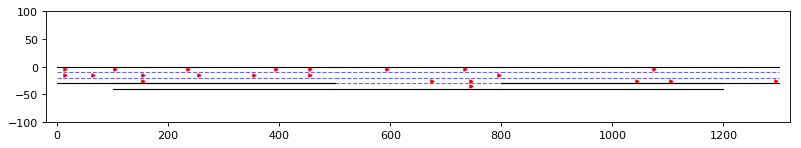

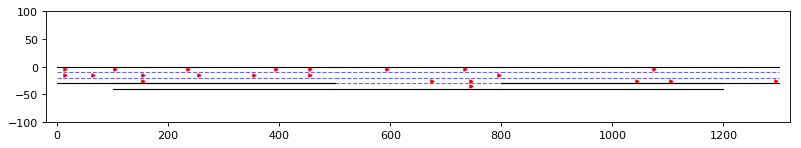

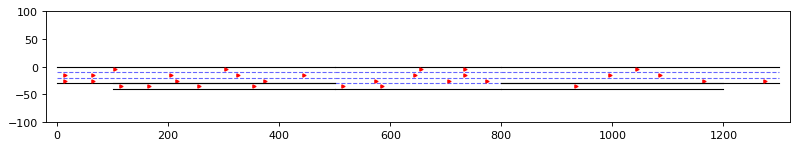

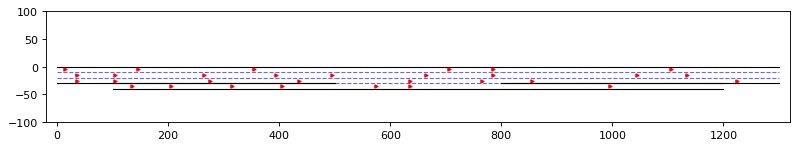

In [354]:
fig = plt.figure(figsize=(12, 4), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
draw_simulation_world(ax, world)
plt.show()

In [348]:
car_artists

{139646581734280: [<matplotlib.lines.Line2D at 0x7f02043d5b00>],
 139646582196744: [<matplotlib.lines.Line2D at 0x7f0204155048>],
 139646582243272: [<matplotlib.lines.Line2D at 0x7f0203990390>],
 139646571783368: [<matplotlib.lines.Line2D at 0x7f02045bfd30>],
 139646571783240: [<matplotlib.lines.Line2D at 0x7f02043d10b8>]}

In [128]:
a.insert(1,"a")

In [134]:
a.pop()

4